# Bruins & Celtics Pregame Analysis

This notebook explores T ridership before Bruins and Celtics games.

## Setup

In [1]:
# Libraries.
import datetime as dt
import math
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Feature libraries.
from features import date

In [2]:
# Package settings.

# Matplotlib.
%matplotlib inline

# Seaborn.
sns.set_style('darkgrid')

In [3]:
# Other settings.

# Default figure size.
default_figsize = (12,8)
default_figsize_slides = (12,6)

# Base units of timedeltas.
timedelta_base = 3.6e12

# Game lengths in hours for coloring.
game_lengths = {
    'Celtics': 2.25,
    'Bruins':  2.3333
}

# Team colors.
team_colors = {
    'Bruins': '#FDB930',
    'Celtics': '#008348'
}

# Season information.
season_start_month = 10
season_end_month   = 6
season_months = np.array(range(season_start_month,13)+range(1,season_end_month+1))

# Pregame time range information.
pregame_hours_back = 6
pregame_hours_after_start = .5

# List of holidays and other bad days to exclude from analysis.
holidays = '2013-01-21,2013-02-10,2013-03-08,2013-10-14,2013-11-11,2013-11-27,2013-11-29,2013-12-26,2013-12-27,2013-12-31,2014-01-02,2014-01-03,2014-01-20,2014-10-13,2014-11-28,2014-12-23,2014-12-26,2014-12-29,2014-12-31,2015-01-02,2015-01-03,2015-02-10'
bad_dates = [dt.date(int(h[:4]),int(h[5:7]),int(h[-2:])) for h in holidays.split(',')]

## Read Data

### Bruins

In [4]:
# Read Bruins home games.
bruins = pd.DataFrame.from_csv("../../../data/bruins/home.csv").reset_index(drop=False)

# Drop home/playoff columns.
bruins.drop(['Home','Playoff'], axis=1, inplace=True)

# Rename other columns to make joining easy.
bruins.rename(columns={'Datetime':'game_datetime', 'Opponent':'opponent'}, inplace=True)

# Get standalone game date.
bruins['game_date'] = pd.to_datetime(pd.DatetimeIndex(bruins.game_datetime).date)

# Turn game date/time into an appropriate object.
# bruins.game_datetime = pd.to_datetime(bruins.game_datetime)

# Add game time column.
bruins['game_time'] = pd.DatetimeIndex(bruins.game_datetime).time

# Remove bad dates.
bruins = bruins[bruins.game_date.isin(bad_dates) == False]

# Add sport column for later merging.
bruins['team'] = 'Bruins'

In [5]:
bruins.head()

,game_datetime,opponent,game_date,game_time,team
0,2013-01-19 19:00:00,NY Rangers,2013-01-19,19:00:00,Bruins
2,2013-01-25 19:00:00,NY Islanders,2013-01-25,19:00:00,Bruins
3,2013-01-29 19:00:00,New Jersey,2013-01-29,19:00:00,Bruins
4,2013-01-31 19:00:00,Buffalo,2013-01-31,19:00:00,Bruins
5,2013-02-12 19:30:00,NY Rangers,2013-02-12,19:30:00,Bruins


### Celtics

In [6]:
# Read Celtics home games.
celtics = pd.DataFrame.from_csv("../../../data/celtics/home.csv").reset_index(drop=False)

# Drop home/playoff columns.
celtics.drop(['Home','Playoff'], axis=1, inplace=True)

# Rename other columns to make joining easy.
celtics.rename(columns={'Datetime':'game_datetime', 'Opponent':'opponent'}, inplace=True)

# Get standalone game date. There must be a better way, but this works for now.
celtics['game_date'] = pd.to_datetime(pd.DatetimeIndex(celtics.game_datetime).date)

# Turn game date/time into an appropriate object.
# celtics.game_datetime = pd.to_datetime(celtics.game_datetime)

# Add game time column.
celtics['game_time'] = pd.DatetimeIndex(celtics.game_datetime).time

# Remove bad dates.
celtics = celtics[celtics.game_date.isin(bad_dates) == False]

# Add sport column for later merging.
celtics['team'] = 'Celtics'

In [7]:
celtics.head()

,game_datetime,opponent,game_date,game_time,team
0,2012-11-02 19:30:00,Milwaukee,2012-11-02,19:30:00,Celtics
1,2012-11-07 19:30:00,Washington,2012-11-07,19:30:00,Celtics
2,2012-11-09 19:30:00,Philadelphia,2012-11-09,19:30:00,Celtics
3,2012-11-14 19:30:00,Utah,2012-11-14,19:30:00,Celtics
4,2012-11-17 12:30:00,Toronto,2012-11-17,12:30:00,Celtics


### Gatecount

In [8]:
# Import gatecount data.
def get_data():
    return pd.DataFrame.from_csv("../../../data/mbta.csv").reset_index()
gatecount = date.init(get_data())

# Restrict to columns that we need.
gatecount = gatecount.ix[:,['locationid','name','line_1','line_2','service_day','service_datetime','entries']].reset_index(drop=True)

# Turn days/dates into datetimes.
gatecount.service_day = pd.to_datetime(gatecount.service_day)
gatecount.service_datetime = pd.to_datetime(gatecount.service_datetime)

# Get time of day.
gatecount['service_time'] = pd.DatetimeIndex(gatecount.service_datetime).time

# Clean line 2.
gatecount.ix[gatecount.line_2.isnull() == True,'line_2'] = 'None'

# Calculate entries per line.
gatecount.ix[gatecount.line_2 == 'None','entries_per_line'] = gatecount.ix[gatecount.line_2 == 'None','entries']
gatecount.ix[gatecount.line_2 != 'None','entries_per_line'] = gatecount.ix[gatecount.line_2 != 'None','entries'] / 2

# Add day of week.
gatecount = date.add_day_of_week(gatecount.copy())

# Remove bad dates.
gatecount = gatecount[gatecount.service_day.isin(bad_dates) == False]

### Farebox

In [9]:
# Path for routes.
routes_file = '../../../data/SignCodesAndRoutes.csv'

# Get routes.
routes = pd.read_csv(routes_file)
# Restrict to Green Line D.
gl_routes = routes[(routes['mode'] == 'G/Line') & routes.publicroute.isin(['Green Line '+l for l in 'BCDE'])]
# Get signcodes.
gl_signcodeids = set(gl_routes.signcodeid)

# Get simplified version for merge.
gl_sc_pr = gl_routes[['signcodeid','publicroute']]

In [10]:
# Farebox directories.
farebox_root = '../../../data/farebox_all/'

# Empty container for data.
farebox = None
# Traverse each file and add to the main.
for farebox_file in os.listdir(farebox_root):
    farebox_month = pd.read_csv(farebox_root+farebox_file)
    if farebox is None:
        farebox = farebox_month
    else:
        farebox = farebox.append(farebox_month)

# Restrict to green line D. Discard old farebox data.
gl_farebox = farebox[farebox.signcodeid.isin(gl_signcodeids)].copy()
del farebox

# Calculate entries.
gl_farebox['entries'] = gl_farebox.charlie + gl_farebox.cash

# Drop old columns.
gl_farebox.drop(['charlie','cash'], axis=1, inplace=True)

# Rename some columns for consistency.
gl_farebox.rename(columns={'servicedate':'service_day', 'servicetime':'service_time'}, inplace=True)

# Make service_day a string for now.
gl_farebox.service_day = gl_farebox.service_day.astype(np.str)

# Fix dates and times for post-midnight 
gl_farebox_post_midnight = gl_farebox[gl_farebox.service_time >= 2400]
# Fix times.
gl_farebox_post_midnight.service_time = gl_farebox_post_midnight.service_time-2400
# Fix dates.
gl_farebox_post_midnight.service_day = pd.to_datetime(gl_farebox_post_midnight.service_day) + np.timedelta64(1,'D')
gl_farebox_post_midnight.service_day = pd.DatetimeIndex(gl_farebox_post_midnight.service_day).format()
# Get pre-midnight data.
gl_farebox_pre_midnight = gl_farebox[gl_farebox.service_time < 2400]
# Recombine.
gl_farebox = gl_farebox_pre_midnight.append(gl_farebox_post_midnight)
# Housekeeping.
del gl_farebox_pre_midnight, gl_farebox_post_midnight

# Zero-pad service times.
gl_farebox.service_time = gl_farebox.service_time.map('{:04}'.format)

# Derive datetime.
gl_farebox['service_datetime'] = pd.to_datetime(gl_farebox.service_day + ' ' + gl_farebox.service_time)

# Re-derive service time.
gl_farebox.service_time = pd.DatetimeIndex(gl_farebox['service_datetime']).time

# Turn plain day into a datetime and get day of week.
gl_farebox.service_day = pd.to_datetime(gl_farebox.service_day)
gl_farebox['day_of_week'] = pd.DatetimeIndex(gl_farebox.service_day).weekday

# Identify outbound/outbound routes.
gl_farebox['inbound'] = (gl_farebox.signcodeid % 10).astype(np.bool)

# Merge with publicroute information.
gl_farebox = gl_farebox.merge(gl_sc_pr, on='signcodeid')

# Aggregate by inbound/outbound, publicroute.
gl_farebox = gl_farebox.groupby(['service_day','service_time','service_datetime','day_of_week','inbound','publicroute']).agg(np.sum).reset_index()

# Perform final aggregation in case of multiple signcodeid entries.
# gl_farebox_agg = gl_farebox.groupby(['service_day','service_time','service_datetime','day_of_week','inbound']).agg(np.sum).reset_index()
gl_farebox.drop(['signcodeid'], axis=1, inplace=True)

# Remove bad dates.
gl_farebox = gl_farebox[gl_farebox.service_day.isin(bad_dates) == False]

/usr/local/Cellar/python/2.7.6/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/generic.py:2005: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


## Merge Data

### Combine All Games

In [11]:
# Merge all games.
games = bruins.append(celtics)

# Get teams set for later traversal.
teams = set(games.team)

### Combine with Gatecount/Farebox

In [12]:
# Merge with Gatecount.
bc_gc = gatecount.merge(games, left_on='service_day', right_on='game_date', how='left')

# Flag days with games.
bc_gc['game_played'] = bc_gc.team.isnull() == False

# Calculate delta from game start to entries record time.
bc_gc['time_until_game_start'] = bc_gc.game_datetime - bc_gc.service_datetime

In [13]:
bc_gc[bc_gc.game_played == True].head()

,locationid,name,line_1,line_2,service_day,service_datetime,entries,service_time,entries_per_line,day_of_week,game_datetime,opponent,game_date,game_time,team,game_played,time_until_game_start
5050,1002,Andrew Square,Red,None,2013-01-02,2013-01-02 04:45:00,2,04:45:00,2,2,2013-01-02 19:30:00,Memphis,2013-01-02,19:30:00,Celtics,True,14:45:00
5051,1002,Andrew Square,Red,None,2013-01-02,2013-01-02 05:00:00,5,05:00:00,5,2,2013-01-02 19:30:00,Memphis,2013-01-02,19:30:00,Celtics,True,14:30:00
5052,1002,Andrew Square,Red,None,2013-01-02,2013-01-02 05:15:00,60,05:15:00,60,2,2013-01-02 19:30:00,Memphis,2013-01-02,19:30:00,Celtics,True,14:15:00
5053,1002,Andrew Square,Red,None,2013-01-02,2013-01-02 05:30:00,54,05:30:00,54,2,2013-01-02 19:30:00,Memphis,2013-01-02,19:30:00,Celtics,True,14:00:00
5054,1002,Andrew Square,Red,None,2013-01-02,2013-01-02 05:45:00,51,05:45:00,51,2,2013-01-02 19:30:00,Memphis,2013-01-02,19:30:00,Celtics,True,13:45:00


In [14]:
# Merge with Farebox.
bc_fb = gl_farebox.merge(games, left_on='service_day', right_on='game_date', how='left')

# Flag days with games.
bc_fb['game_played'] = (bc_fb.opponent.isnull() == False)

# Calculate delta from game start to entries record time.
bc_fb['time_until_game_start'] = bc_fb.game_datetime - bc_fb.service_datetime

In [15]:
bc_fb[bc_fb.game_played == True].head()

,service_day,service_time,service_datetime,day_of_week,inbound,publicroute,entries,game_datetime,opponent,game_date,game_time,team,game_played,time_until_game_start
554,2013-01-02,00:00:00,2013-01-02,2,False,Green Line D,6,2013-01-02 19:30:00,Memphis,2013-01-02,19:30:00,Celtics,True,19:30:00
555,2013-01-02,00:00:00,2013-01-02,2,False,Green Line E,2,2013-01-02 19:30:00,Memphis,2013-01-02,19:30:00,Celtics,True,19:30:00
556,2013-01-02,00:00:00,2013-01-02,2,True,Green Line B,5,2013-01-02 19:30:00,Memphis,2013-01-02,19:30:00,Celtics,True,19:30:00
557,2013-01-02,00:00:00,2013-01-02,2,True,Green Line C,7,2013-01-02 19:30:00,Memphis,2013-01-02,19:30:00,Celtics,True,19:30:00
558,2013-01-02,00:00:00,2013-01-02,2,True,Green Line E,0,2013-01-02 19:30:00,Memphis,2013-01-02,19:30:00,Celtics,True,19:30:00


### Game Entries

Restrict GC/FB data to gamedays.

In [16]:
# Initial filter and pruning.
bc_gc_game = bc_gc[bc_gc.game_played == True].copy()
# Convert time to game to int.
bc_gc_game['hours_until_game_start'] = bc_gc_game.time_until_game_start.astype(np.int) / timedelta_base
# Prune columns.
bc_gc_game = bc_gc_game[['team','game_date','name','line_1','line_2','service_time','hours_until_game_start','day_of_week','entries','entries_per_line']]
# Filter on hours until start.
bc_gc_game = bc_gc_game[(bc_gc_game.hours_until_game_start <= pregame_hours_back) & (bc_gc_game.hours_until_game_start >= -pregame_hours_after_start)]

In [17]:
bc_gc_game.head()

,team,game_date,name,line_1,line_2,service_time,hours_until_game_start,day_of_week,entries,entries_per_line
5085,Celtics,2013-01-02,Andrew Square,Red,None,13:30:00,6.00,2,64,64
5086,Celtics,2013-01-02,Andrew Square,Red,None,13:45:00,5.75,2,47,47
5087,Celtics,2013-01-02,Andrew Square,Red,None,14:00:00,5.50,2,63,63
5088,Celtics,2013-01-02,Andrew Square,Red,None,14:15:00,5.25,2,73,73
5089,Celtics,2013-01-02,Andrew Square,Red,None,14:30:00,5.00,2,75,75


In [18]:
# Initial filter and pruning.
bc_fb_game = bc_fb[bc_fb.game_played == True].copy()
# Convert time to game to int.
bc_fb_game['hours_until_game_start'] = bc_fb_game.time_until_game_start.astype(np.int) / timedelta_base
# Prune columns.
bc_fb_game = bc_fb_game[['team','game_date','publicroute','service_time','hours_until_game_start','day_of_week','entries']]
# Filter on hours until start.
bc_fb_game = bc_fb_game[(bc_fb_game.hours_until_game_start <= pregame_hours_back) & (bc_fb_game.hours_until_game_start >= -pregame_hours_after_start)]

In [19]:
bc_fb_game.head()

,team,game_date,publicroute,service_time,hours_until_game_start,day_of_week,entries
853,Celtics,2013-01-02,Green Line B,13:30:00,6,2,78
854,Celtics,2013-01-02,Green Line C,13:30:00,6,2,18
855,Celtics,2013-01-02,Green Line D,13:30:00,6,2,37
856,Celtics,2013-01-02,Green Line E,13:30:00,6,2,37
857,Celtics,2013-01-02,Green Line B,13:30:00,6,2,96


## Aggregations

Generate aggregations here for easy consumption later.

### Gatecount Data

Aggregate gameless entries.

In [20]:
# Restrict to season.
record_months = pd.DatetimeIndex(bc_gc.service_day).month
bc_gc_gameless = bc_gc.ix[(record_months >= season_start_month) | (record_months <= season_end_month),:]

# Perform grouping.
bc_gc_gameless = bc_gc_gameless[bc_gc_gameless.game_played == False].groupby(['name','line_1','line_2','day_of_week','service_time']).agg({'entries':np.mean,'entries_per_line':np.mean}).reset_index()
bc_gc_gameless.rename(columns={'entries':'mean_entries', 'entries_per_line':'mean_entries_per_line'}, inplace=True)

In [22]:
bc_gc_gameless[bc_gc_gameless.mean_entries_per_line < bc_gc_gameless.mean_entries].head()

,name,line_1,line_2,day_of_week,service_time,mean_entries_per_line,mean_entries
12735,Downtown Crossing,Orange,Red,0,00:00:00,14.347458,28.694915
12736,Downtown Crossing,Orange,Red,0,00:15:00,9.750000,19.500000
12737,Downtown Crossing,Orange,Red,0,00:30:00,5.775000,11.550000
12738,Downtown Crossing,Orange,Red,0,00:45:00,4.050847,8.101695
12739,Downtown Crossing,Orange,Red,0,01:00:00,2.958333,5.916667


### Farebox Data

In [23]:
# Restrict to season.
record_months = pd.DatetimeIndex(bc_fb.service_day).month
bc_fb_gameless = bc_fb.ix[(record_months >= season_start_month) | (record_months <= season_end_month),:]

# Perform grouping.
bc_fb_gameless = bc_fb_gameless[bc_fb_gameless.game_played == False].groupby(['publicroute','day_of_week','service_time']).agg({'entries':np.mean}).reset_index()
bc_fb_gameless.rename(columns={'entries':'mean_entries'}, inplace=True)

In [24]:
bc_fb_gameless.head()

,publicroute,day_of_week,service_time,mean_entries
0,Green Line B,0,00:00:00,19.673684
1,Green Line B,0,00:15:00,15.890110
2,Green Line B,0,00:30:00,6.444444
3,Green Line B,0,00:45:00,5.071429
4,Green Line B,0,01:00:00,4.423077


## Amalgamations

### Core Comparisons

For aggregate comparisons we need to bring everything back together. Do Gatecount and Farebox here.

In [25]:
# Perform join.
bc_gc_game_comp = bc_gc_game.merge(bc_gc_gameless, on=['name','line_1','line_2','day_of_week','service_time'])

# Calculate differences.
bc_gc_game_comp['entries_vs_mean']          = bc_gc_game_comp.entries - bc_gc_game_comp.mean_entries
bc_gc_game_comp['entries_per_line_vs_mean'] = bc_gc_game_comp.entries_per_line - bc_gc_game_comp.mean_entries_per_line

In [26]:
bc_gc_game_comp.head()

,team,game_date,name,line_1,line_2,service_time,hours_until_game_start,day_of_week,entries,entries_per_line,mean_entries_per_line,mean_entries,entries_vs_mean,entries_per_line_vs_mean
0,Celtics,2013-01-02,Andrew Square,Red,None,13:30:00,6,2,64,64,69.382979,69.382979,-5.382979,-5.382979
1,Celtics,2013-01-09,Andrew Square,Red,None,13:30:00,6,2,61,61,69.382979,69.382979,-8.382979,-8.382979
2,Celtics,2013-01-30,Andrew Square,Red,None,13:30:00,6,2,72,72,69.382979,69.382979,2.617021,2.617021
3,Celtics,2013-02-13,Andrew Square,Red,None,13:30:00,6,2,82,82,69.382979,69.382979,12.617021,12.617021
4,Celtics,2013-03-13,Andrew Square,Red,None,13:30:00,6,2,82,82,69.382979,69.382979,12.617021,12.617021


In [27]:
# Perform join.
bc_fb_game_comp = bc_fb_game.merge(bc_fb_gameless, on=['publicroute','day_of_week','service_time'])

# Calculate differences.
bc_fb_game_comp['entries_vs_mean'] = bc_fb_game_comp.entries - bc_fb_game_comp.mean_entries

In [28]:
bc_fb_game_comp.head()

,team,game_date,publicroute,service_time,hours_until_game_start,day_of_week,entries,mean_entries,entries_vs_mean
0,Celtics,2013-01-02,Green Line B,13:30:00,6,2,78,106.477273,-28.477273
1,Celtics,2013-01-02,Green Line B,13:30:00,6,2,96,106.477273,-10.477273
2,Celtics,2013-01-09,Green Line B,13:30:00,6,2,118,106.477273,11.522727
3,Celtics,2013-01-09,Green Line B,13:30:00,6,2,59,106.477273,-47.477273
4,Celtics,2013-01-30,Green Line B,13:30:00,6,2,165,106.477273,58.522727


### Station Means

Use the DFs above to get mean lifts for stations.

In [29]:
# Aggregate by game-station and sum lift.
bc_gc_game_name_entries = bc_gc_game_comp.groupby(['team','game_date','name','line_1','line_2']).agg({'mean_entries':np.sum,'entries_vs_mean':np.sum}).reset_index()
# Now get mean by station.
bc_gc_name_entries = bc_gc_game_name_entries.groupby(['name','line_1','line_2']).agg({'mean_entries':np.mean,'entries_vs_mean':np.mean}).reset_index()
# Add proportional measure.
bc_gc_name_entries['entries_vs_mean_proportional'] = 100 * bc_gc_name_entries.entries_vs_mean / bc_gc_name_entries.mean_entries
# Sort.
bc_gc_name_entries.sort('entries_vs_mean', ascending=False, inplace=True)

In [30]:
bc_gc_name_entries.head()

,name,line_1,line_2,mean_entries,entries_vs_mean,entries_vs_mean_proportional
19,Downtown Crossing,Orange,Red,11852.800144,552.663944,4.662729
6,Back Bay,Orange,None,7649.260641,471.225547,6.160406
47,Ruggles,Orange,None,4600.904537,449.161761,9.762466
55,Sullivan Square,Orange,None,3208.401127,401.090586,12.501261
27,JFK/U Mass,Red,None,3404.725817,392.964791,11.541746


### Gatecount/Farebox Join

Wrangle Gatecount and Farebox data together. We will have to (1) ensure similar columns, (2) concatenate, and (3) sum by game.

In [31]:
# Rearrange GC data.
bc_gc_game_comp_amalg = bc_gc_game_comp[['team','game_date','line_1','line_2','hours_until_game_start','entries_vs_mean','entries_per_line_vs_mean']]

# Rearrange FB data.
bc_fb_game_comp_amalg = bc_fb_game_comp[['team','game_date','hours_until_game_start','entries_vs_mean']].copy()
bc_fb_game_comp_amalg['entries_per_line_vs_mean'] = bc_fb_game_comp_amalg.entries_vs_mean
bc_fb_game_comp_amalg['line_1'] = 'Green'
bc_fb_game_comp_amalg['line_2'] = 'None'

# Concatenate
bc_gcfb_game_comp_amalg = bc_gc_game_comp_amalg.append(bc_fb_game_comp_amalg)

# Aggregate.
bc_gcfb_game_comp = bc_gcfb_game_comp_amalg.groupby(['team','line_1','line_2','game_date','hours_until_game_start']).sum().reset_index()

# Get rid of bad days.
bc_gcfb_game_comp = bc_gcfb_game_comp[bc_gcfb_game_comp.game_date.isin(bad_dates) == False]

In [32]:
bc_gcfb_game_comp.head()

,team,line_1,line_2,game_date,hours_until_game_start,entries_per_line_vs_mean,entries_vs_mean
0,Bruins,Blue,None,2013-01-19,-0.50,-23.902383,-23.902383
1,Bruins,Blue,None,2013-01-19,-0.25,-57.528510,-57.528510
2,Bruins,Blue,None,2013-01-19,0.00,-32.094449,-32.094449
3,Bruins,Blue,None,2013-01-19,0.25,-55.708446,-55.708446
4,Bruins,Blue,None,2013-01-19,0.50,-93.517413,-93.517413


The result of this is aggregate differences from mean for each game, along each line and time before/after start. The next few calculations group things in different ways.

In [33]:
# Get sum by hours until game start for each game. Then aggregate by team.
game_hourly_agg_comp = bc_gcfb_game_comp.groupby(['team','game_date','hours_until_game_start']).agg({'entries_vs_mean':np.sum}).reset_index()
hourly_agg_comp = game_hourly_agg_comp.groupby(['team','hours_until_game_start']).agg({'entries_vs_mean':np.mean}).reset_index()

In [34]:
# Container for data.
line_entries_hourly_comp = None
# Traverse lines.
for l in bc_gcfb_game_comp.line_1.unique():
    line_comp = bc_gcfb_game_comp[(bc_gcfb_game_comp.line_1 == l) | (bc_gcfb_game_comp.line_2 == l)].copy()
    line_comp = line_comp.groupby(['team','game_date','hours_until_game_start']).agg({'entries_per_line_vs_mean':np.sum}).reset_index()
    # Now we have data by game-hours for both teams. Simply take hourly average and append to main DF above.
    line_comp = line_comp.groupby('hours_until_game_start').agg({'entries_per_line_vs_mean':np.mean}).reset_index()
    line_comp.rename(columns={'entries_per_line_vs_mean':'mean_entries_per_line_vs_mean'}, inplace=True)
    line_comp['line'] = l
    if line_entries_hourly_comp is None:
        line_entries_hourly_comp = line_comp.copy()
    else:
        line_entries_hourly_comp = line_entries_hourly_comp.append(line_comp)

Calculate sums by team, line.

In [35]:
# Group and sum by team.
team_agg_comp = hourly_agg_comp.groupby('team').agg({'entries_vs_mean':np.sum}).reset_index()
team_agg_comp

,team,entries_vs_mean
0,Bruins,9579.143530
1,Celtics,7494.203659


In [36]:
# Group and sum by line.
line_agg_comp = line_entries_hourly_comp.groupby('line').agg({'mean_entries_per_line_vs_mean':np.sum}).reset_index()
line_agg_comp = line_agg_comp[line_agg_comp.line != 'Silver']
line_agg_comp.sort('mean_entries_per_line_vs_mean', ascending=False, inplace=True)
line_agg_comp

,line,mean_entries_per_line_vs_mean
2,Orange,3306.570730
3,Red,2926.727768
1,Green,2369.605320
0,Blue,-26.590553


---

## Aggregate Analysis

### Main Analysis

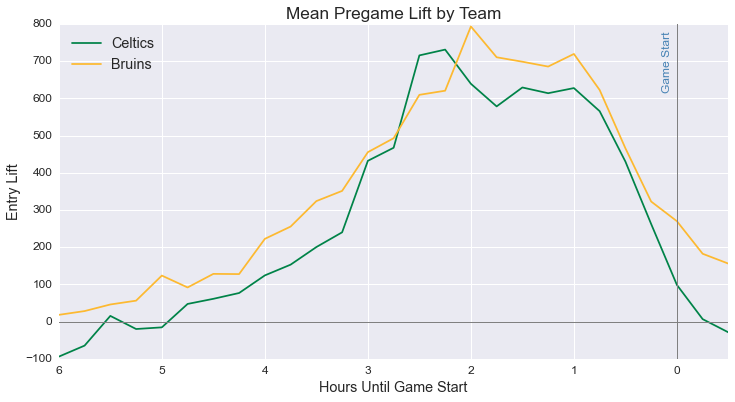

In [37]:
# Plot mean diffs per hour for both teams.
# Start plot.
plt.figure(figsize=default_figsize_slides)
# Plot each team.
for team in teams:
    team_agg_comp = hourly_agg_comp[hourly_agg_comp.team == team].copy()
    plt.plot(team_agg_comp.hours_until_game_start, team_agg_comp.entries_vs_mean, color=team_colors[team], label=team)

# Limits.
ylim = plt.ylim(); xlim = plt.xlim((team_agg_comp.hours_until_game_start.min(), team_agg_comp.hours_until_game_start.max()))

# Lines and labels.
plt.axvline(0, *ylim, color='gray', lw=1)
plt.axhline(0, *xlim, color='gray', lw=1)
plt.annotate('Game Start', (.05,ylim[1]*0.95), rotation='vertical', ha='right', color='steelblue', fontsize='large')

# Fix limits and axes.
plt.gca().invert_xaxis()

# Text.
plt.title('Mean Pregame Lift by Team', fontsize='xx-large')
plt.legend(fontsize='x-large', loc=2)
plt.xticks(fontsize='large'); plt.yticks(fontsize='large')
plt.xlabel('Hours Until Game Start', fontsize='x-large')
plt.ylabel('Entry Lift', fontsize='x-large')
             
# Show.
plt.show()

### Range

TODO

## Station Analysis

### Histogram

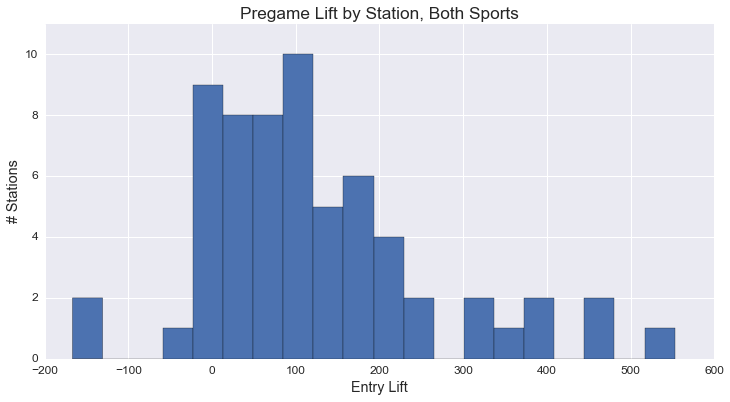

In [38]:
# Start plot.
plt.figure(figsize=default_figsize_slides)

# Plot 
plt.hist(bc_gc_name_entries.entries_vs_mean, bins=20)

# Text.
plt.title('Pregame Lift by Station, Both Sports', fontsize='xx-large')
plt.xticks(fontsize='large'); plt.yticks(fontsize='large')
plt.xlabel('Entry Lift', fontsize='x-large')
plt.ylabel('# Stations', fontsize='x-large')

# Adjust limits.
plt.ylim(0,plt.ylim()[1]+1)

# Show.
plt.show()

### Top Stations

In [39]:
bc_gc_name_entries.head(n=30)

,name,line_1,line_2,mean_entries,entries_vs_mean,entries_vs_mean_proportional
19,Downtown Crossing,Orange,Red,11852.800144,552.663944,4.662729
6,Back Bay,Orange,None,7649.260641,471.225547,6.160406
47,Ruggles,Orange,None,4600.904537,449.161761,9.762466
55,Sullivan Square,Orange,None,3208.401127,401.090586,12.501261
27,JFK/U Mass,Red,None,3404.725817,392.964791,11.541746
29,Kendall Square,Red,None,7994.490075,342.078985,4.278934
16,Copley Square,Green,None,6374.306990,323.306270,5.072022
51,South Station,Red,None,10536.752624,314.241851,2.982341
15,Community College,Orange,None,1846.589703,249.499186,13.511349
4,Arlington,Green,None,4117.517451,248.698019,6.039999


## Line Analysis

### Trends

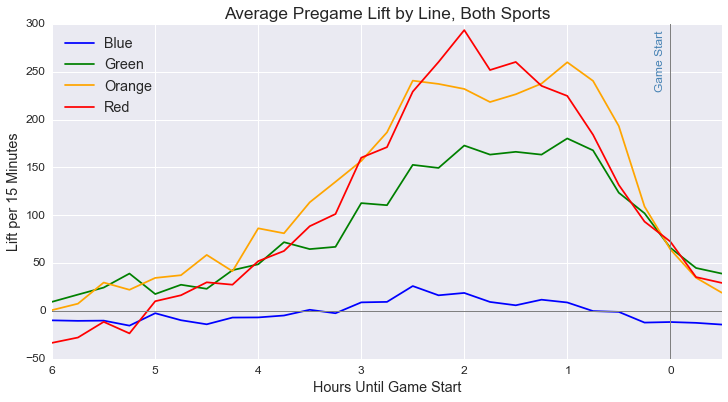

In [40]:
# Start plot.
plt.figure(figsize=default_figsize_slides)

# Traverse lines and plot each:
for l in line_entries_hourly_comp.line.unique():
    if l != 'Silver':
        l_entries = line_entries_hourly_comp[line_entries_hourly_comp.line == l]
        plt.plot(l_entries.hours_until_game_start, l_entries.mean_entries_per_line_vs_mean, c=l, label=l)

# Limits.
ylim = plt.ylim(); xlim = plt.xlim((line_entries_hourly_comp.hours_until_game_start.min(), line_entries_hourly_comp.hours_until_game_start.max()))

# Lines and labels.
plt.axvline(0, *ylim, color='gray', lw=1)
plt.axhline(0, *xlim, color='gray', lw=1)
plt.annotate('Game Start', (.05,ylim[1]*0.95), rotation='vertical', ha='right', color='steelblue', fontsize='large')

# Fix limits and axes.
plt.gca().invert_xaxis()

# Text.
plt.title('Average Pregame Lift by Line, Both Sports', fontsize='xx-large')
plt.legend(fontsize='x-large', loc=2)
plt.xticks(fontsize='large'); plt.yticks(fontsize='large')
plt.xlabel('Hours Until Game Start', fontsize='x-large')
plt.ylabel('Lift per 15 Minutes', fontsize='x-large')
             
# Show.
plt.show()

### Bar Chart

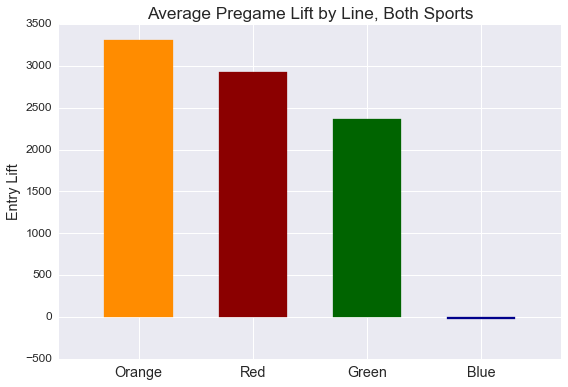

In [41]:
# Bar plot.
plt.figure(figsize=(default_figsize_slides[0]*.75,default_figsize_slides[1]))

# Bar settings.
bar_width = .6

# Plot.
bars = plt.bar(range(len(line_agg_comp)), line_agg_comp.mean_entries_per_line_vs_mean, width=bar_width)

# Color bars.
for bar,line in zip(bars,line_agg_comp.line):
    bar.set_color('dark'+line)

# Prettify.
plt.title('Average Pregame Lift by Line, Both Sports', fontsize='xx-large')
plt.ylabel('Entry Lift', fontsize='x-large')
plt.xlim(-(1-bar_width),plt.xlim()[1])
plt.xticks(np.arange(len(line_agg_comp))+bar_width/2,list(line_agg_comp.line),fontsize='x-large')
plt.yticks(fontsize='large')

# Show.
plt.show()